In [1]:
import numpy as np
import math


In [2]:
from pathlib import Path
import os

# root = Path(__file__).parent.parent  # top-level directory
root = Path(os.getcwd()).parent  # top-level directory

DATA_PATH = root / "data/"  # datasets and pretrained weights
TRAINING_PATH = root / "outputs/training/"  # training checkpoints
EVAL_PATH = root / "outputs/results/"  # evaluation results


In [3]:
def read_image(path: Path, grayscale: bool = False) -> np.ndarray:
    """Read an image from path as RGB or grayscale"""
    if not Path(path).exists():
        raise FileNotFoundError(f"No image at path {path}.")
    mode = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    image = cv2.imread(str(path), mode)
    if image is None:
        raise IOError(f"Could not read image at {path}.")
    if not grayscale:
        image = image[..., ::-1]
    return image


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import os
print(os.getcwd())
from gluefactory.models.deeplsd_inference import DeepLSD

/Users/felixdev/ETH_Informatik_Master/FS24/3D_Vision/glue-factory


In [5]:
def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [11]:
# extract lines for the image
from torchvision.transforms import Resize
from gluefactory.models.lines.deeplsd import DeepLSD
import matplotlib.pyplot as plt
import cv2
from gluefactory.datasets.homographies_deeplsd import warp_lines
from gluefactory.geometry.homography import warp_lines_torch
from gluefactory.datasets.homographies import sample_homography
from homography_adaptation import torch_homography_adaptation


conf_lines = {
    "min_length": 25,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}

size = (800,800)

conf_homography = {
    'translation': True,
    'rotation': True,
    'scaling': True,
    'perspective': True,
    'scaling_amplitude': 0.2,
    'perspective_amplitude_x': 0.2,
    'perspective_amplitude_y': 0.2,
    'patch_ratio': 0.85,
    'max_angle': 1.57,
    'allow_artifacts': True
}
resize_func = Resize(size)
image_path = "data/mini_depth_100/30623106092_3985ec298a_o.jpg"
img = cv2.resize(cv2.imread(image_path),size)
img_torch = numpy_image_to_torch(img)
img_torch = img_torch.unsqueeze(0)
#homography =  sample_homography(img,conf_homography,size)
#warped_img = homography["image"]
#warped_img = numpy_image_to_torch(warped_img)

#warped_img = warped_img.unsqueeze(0)


model2 = DeepLSD(conf_lines)


model2.eval()
#with torch.no_grad():
#    pred2 = model2({"image": warped_img})
#    
#    # pred2 = {k: v[0].cpu().numpy() for k, v in pred2.items()}
#    lines = pred2["lines"]
    # line_scores = pred2["line_scores"]
    # valid_lines = pred2["valid_lines"]
    
# Show lines
#print(lines[0][0][0])

distance_field, angle_field, _ = torch_homography_adaptation(img_torch,model2,num_H=10)

#print(lines.shape)
#lines = lines.numpy()
#lines[0] = warp_lines(lines[0],homography)
#warped_img = cv2.cvtColor(warped_img[0].permute(1,2,0).numpy(),cv2.COLOR_BGR2RGB)
#plt.imshow(warped_img)
#for line in lines[0]:
#    plt.plot(line[:, 0], line[:, 1], c='r')
#plt.show()

torch.Size([10, 800, 800, 2])


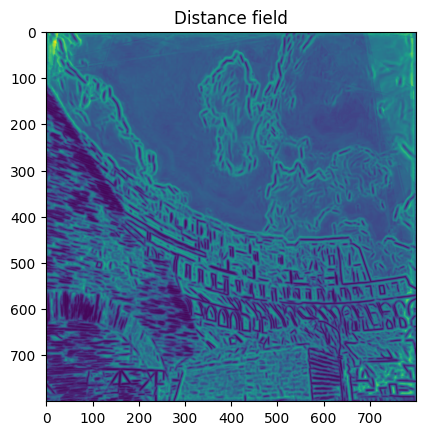

In [14]:
plt.title("Distance field")
plt.imshow(distance_field)

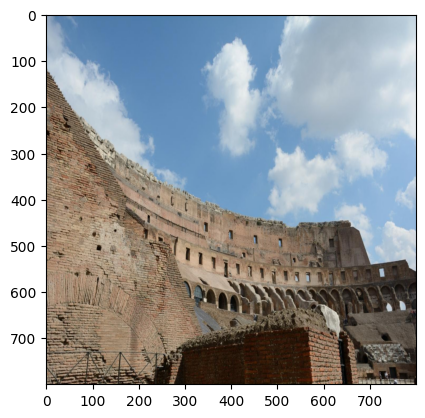

In [17]:
#plt.title("Angle field")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

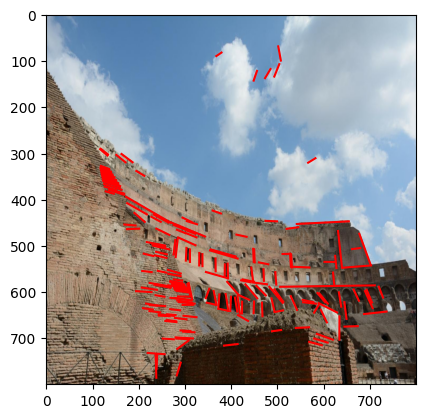

In [29]:
from gluefactory.geometry.homography import warp_points

#h_inv = np.linalg.inv(homography["H_"])
warped_lines = warp_points(lines[0].reshape(-1, 2), homography["H_"]).reshape(-1, 2, 2)

#lines[0] = warp_lines(lines[0],h_inv)
#warped_back_img = cv2.warpPerspective(warped_img, h_inv, size,
#                                         borderMode=cv2.BORDER_REPLICATE)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
for line in warped_lines:
    plt.plot(line[:, 0], line[:, 1], c='r')
plt.show()